# Analyzing movie data to determine most profitable genres, studios, and directors

In [549]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings
import sqlite3
import zipfile
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [550]:
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')

conn = sqlite3.connect('zippedData/im.db')


In [551]:
q="""
SELECT * FROM sqlite_master"""

pd.read_sql(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


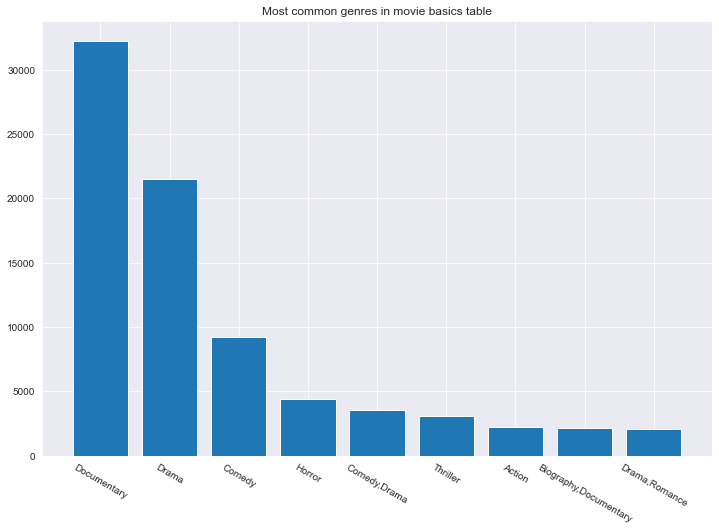

In [552]:
#Finding the most common genres from movie_basics

q="""
SELECT genres, COUNT() AS count
FROM movie_basics
GROUP BY genres
ORDER BY COUNT() DESC
LIMIT 10
"""

gcounts=pd.DataFrame(pd.read_sql(q, conn))
gcounts.drop(gcounts.index[3], inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(gcounts['genres'], gcounts['count'])
ax.set_title('Most common genres in movie basics table')
ax.set_xticklabels(gcounts['genres'], rotation=-30, ha='center');


In [553]:
#Filtering data to get directors who are still alive. Removing unnecessary columns. Joining data so that movie, genre, and director are all in the same table. 

q="""

WITH living_directors AS(
SELECT mb.movie_id, primary_title, start_year, runtime_minutes, genres, p.person_id, primary_name, birth_year, death_year, primary_profession FROM movie_basics mb
INNER JOIN directors d
ON mb.movie_id=d.movie_id
INNER JOIN persons p
ON d.person_id =p.person_id
GROUP BY mb.movie_id
HAVING p.death_year is NULL
)

SELECT * FROM living_directors
"""
#Converting data to dataframe
director_df=pd.read_sql(q, conn)


In [554]:
#Closing SQL connection
conn.close()

In [555]:
#Reading in the dataframes

movie_info=pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
tmdb=pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets=pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
movie_gross=pd.read_csv("zippedData/bom.movie_gross.csv.gz")
reviews=pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

Adding in the tmdb genre id dictionary:

In [556]:
#Data dictionary from tmdb website

tmdb_genres={
'Action':        28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':        9648,
'Romance':         10749,
'Science Fiction': 878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37}

#### First step - cleaning the data.

In [557]:
#Cleaning tmdb to remove dupes. Adding a column including title and year to prepare for merge.
tmdb['title_and_year']=tmdb['original_title']+' ' +tmdb['release_date'].apply(lambda x: x[:4])
tmdb=tmdb.drop_duplicates(subset='id', keep='first')
tmdb=tmdb.drop_duplicates(subset='title_and_year', keep='first')


In [558]:
#Creating a matching column in movie_budgets to prepare for merge
movie_budgets['title_and_year']=movie_budgets['movie']+' ' +movie_budgets['release_date'].apply(lambda x: x[-4:])


In [559]:
#Creating numeric columns to represent Budget and Revenue
movie_budgets['revenue']=movie_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)
movie_budgets['budget']=movie_budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)

#Removing duplicates
movie_budgets=movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

### Creating a new dataframe to compare revenue, genres, and ratings.

In [560]:
#Merging the two dataframes. Inner merge so that we can examine movies for which we have data on both budget and tmdb votes.
tmdb_and_budgets=pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')

#Dropping rows that have $0 as the value for revenue. Further research showed that many of these movies were released directly to streaming services.
tmdb_and_budgets=tmdb_and_budgets.loc[tmdb_and_budgets['revenue']!=0]

In this section we will conduct linear regression tests on the variables budget, vote average, and revenue to see how they are related.

In [561]:
#Linear regression model comparing budget and vote average
X=tmdb_and_budgets['budget']
y=tmdb_and_budgets['vote_average']
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     23.58
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           1.32e-06
Time:                        01:58:57   Log-Likelihood:                -1854.5
No. Observations:                1504   AIC:                             3713.
Df Residuals:                    1502   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2627      0.028    226.929      0.000       6.209       6.317
budget      1.869e-09   3.85e-10      4.856      0.000    1.11e-09    2.62e-09
==============================================================================
Omnibus:                       32.028   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.793
Skew:                          -0.290   Prob(JB):                     6.21e-09
Kurtosis:                       3.516   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-values are less than 0.05, which indicate our model is statistically significant. However the R-squared value is very low, implying that budget explains only 1.5% of the variability in the vote averages. Therefore a higher budget is not a strong predictor of substantially higher votes.

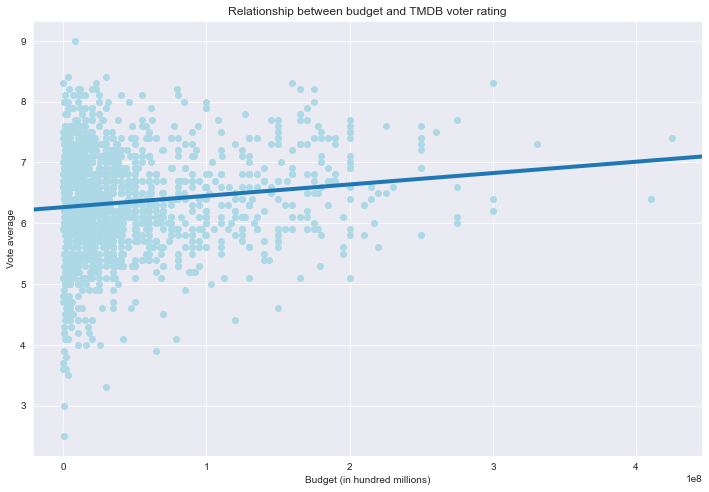

In [562]:
#Displaying our linear regression model for budget and TMDB voter rating

fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(X, y, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Vote average')
ax.set_title('Relationship between budget and TMDB voter rating')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

#### Linear regression model for budget and revenue.

In [563]:
#Creating linear regression model comparing budget's impact on revenue.

X=tmdb_and_budgets['budget']
y=tmdb_and_budgets['revenue']
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2533.
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        01:58:57   Log-Likelihood:                -30421.
No. Observations:                1504   AIC:                         6.085e+04
Df Residuals:                    1502   BIC:                         6.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.404e+06    4.9e+06     -1.921      0.055    -1.9e+07       2e+05
budget         3.4360      0.068     50.332      0.000       3.302       3.570
==============================================================================
Omnibus:                      808.821   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13310.254
Skew:                           2.128   Prob(JB):                         0.00
Kurtosis:                      16.938   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-value for the y-intercept is slight higher than 0.05, so we conclude that the y-intercept in the model is not statistically significant. However the p-value for budget is less than 0.05 and the R-squared is 0.628, implying 62.8% of the variability in revenue is explained by budget. The slope is 3.436, indicating that for every additional dollar spent on budget we expect about $3.43 extra in revenue. However as the graph below shows, it is worth noting that the outlier values tend to be more extreme the higher the budget is.

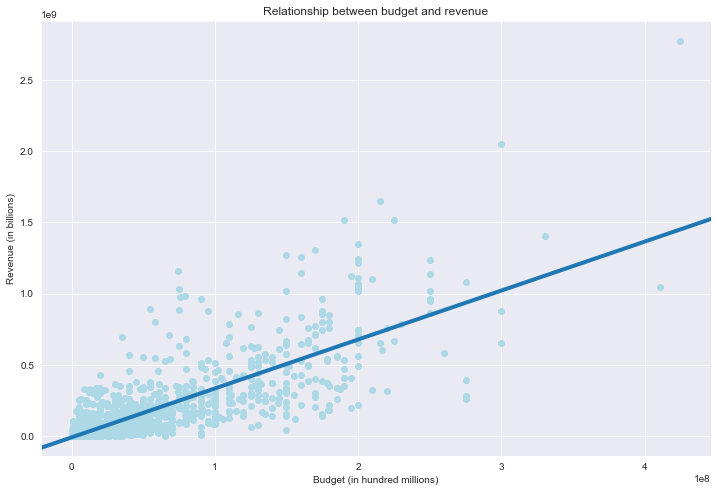

In [564]:
#Plotting linear regression model for budget and revenue.

fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(X, y, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Revenue (in billions)')
ax.set_title('Relationship between budget and revenue')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

We will now examine the most common studios from the movie info dataset.

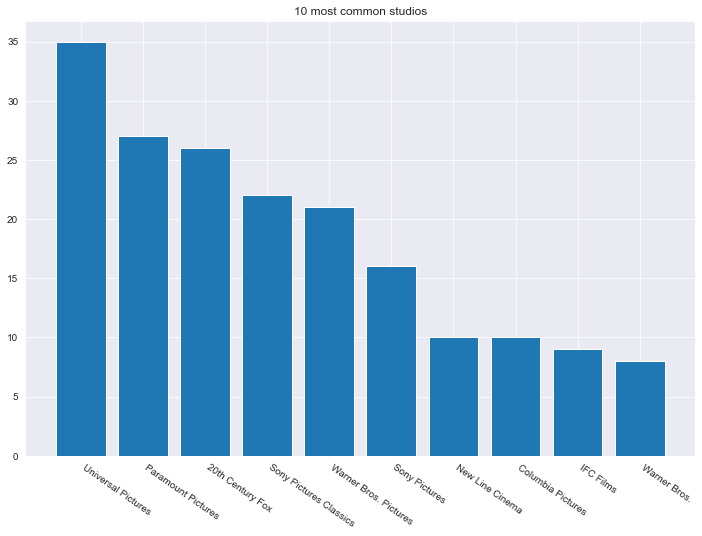

In [565]:
fig, ax=plt.subplots(figsize=(12,8))
ax.bar(movie_info['studio'].value_counts()[:10].index, movie_info['studio'].value_counts()[:10].values)
ax.set_xticklabels(movie_info['studio'].value_counts()[:10].index, rotation=-35, ha='left')
ax.set_title('10 most common studios');

We can see that Universal is the most common movie studio, follow by Paramount and 20th Century Fox.

Next we will examine which genres appear most frequently in our merged dataset.

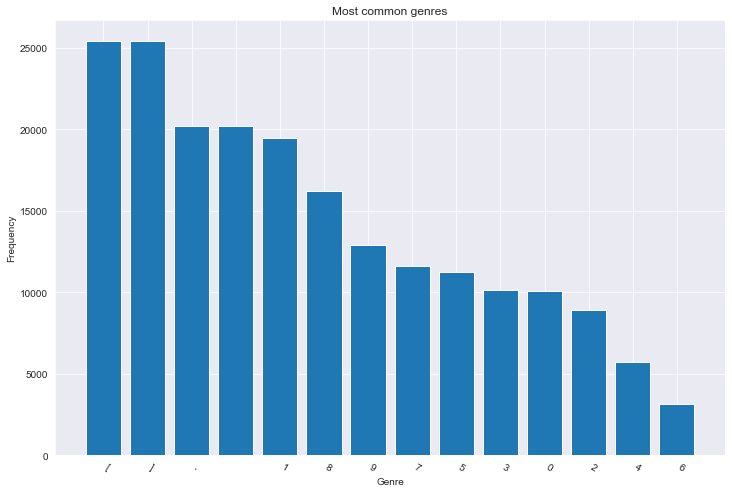

In [566]:
#Dictionary to keep track of how many times each genre appears in the data.

genre_counts={}
for row in tmdb['genre_ids']:
    for l in row:
        if l in genre_counts.keys():
            genre_counts[l]+=1
        else:
            genre_counts[l]=1

gcdf=pd.DataFrame(index=genre_counts.keys(), data=genre_counts.values(), columns={'Frequency'}).sort_values(by='Frequency', ascending=False)
fig, ax=plt.subplots(figsize=(12,8))
ax.bar(gcdf.index, gcdf['Frequency'])
ax.set_xticklabels(gcdf.index, rotation=-30, ha='left')
ax.set_title('Most common genres')
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency');

Examining average revenue by year:

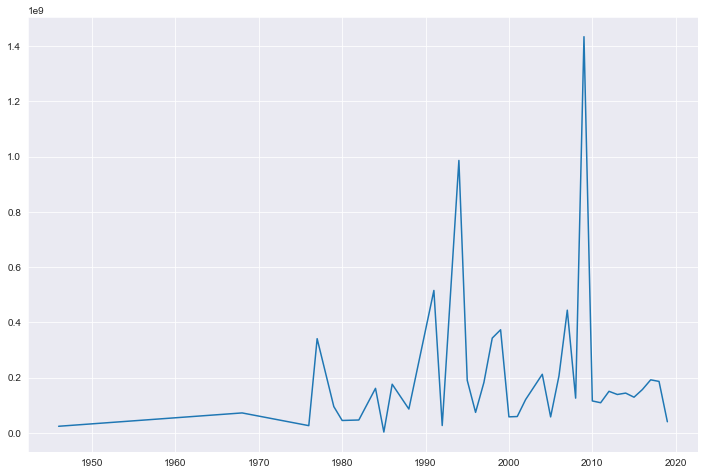

In [567]:
tmdb_and_budgets['year']=tmdb_and_budgets['release_date_y'].apply(lambda x: x[:4]).astype(int)
revenue_by_year=tmdb_and_budgets.groupby('year')['revenue'].mean()

fig, ax=plt.subplots(figsize=(12, 8))
ax.plot(revenue_by_year.index, revenue_by_year.values);

As we will show below, year is not a good predictor of revenue.

In [568]:
X=revenue_by_year.index
y=revenue_by_year.values
model=sm.OLS(y, sm.add_constant(X))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8618
Date:                Wed, 21 Jun 2023   Prob (F-statistic):              0.359
Time:                        01:58:58   Log-Likelihood:                -790.97
No. Observations:                  38   AIC:                             1586.
Df Residuals:                      36   BIC:                             1589.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.987e+09   5.59e+09     -0.891      0.379   -1.63e+10    6.36e+09
x1            2.6e+06    2.8e+06      0.928      0.359   -3.08e+06    8.28e+06
==============================================================================
Omnibus:                       49.578   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.245
Skew:                           3.119   Prob(JB):                     2.02e-49
Kurtosis:                      13.134   Cond. No.                     2.53e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-values are much too high for the model to be considered statistically significant. Therefore we conclude year is not a good predictor of revenue.

We will now examine the relationship between genres and revenue by creating a dictionary. 

In [569]:
#reset index due to dropping rows
tmdb_and_budgets.reset_index(inplace=True)

#removing unnecessary columns
tmdb_and_budgets.drop(['index', 'id_x', 'id_y', 'Unnamed: 0'], axis=1, inplace=True)

tmdb['genre_ids']=tmdb['genre_ids'].str.split()
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].str.split()

In [570]:
#Removing rows from the dataset that don't contain a genre
bad_values=[tmdb_and_budgets['genre_ids'].iloc[1451]]
tmdb_and_budgets=tmdb_and_budgets.loc[~tmdb_and_budgets['genre_ids'].isin(bad_values)]

#Creating a new dictionary, flipping the keys and values from the tmdb data dictionary
tmdb_genres_new={}
for v, k in zip(tmdb_genres.values(), tmdb_genres.keys()):
    tmdb_genres_new[str(v)]=k

#Creating function to convert genre_id strings into lists
def genre_fixer(g_i):
    if len(g_i)>1:
        cleaned_g_i=[]
        cleaned_g_i.append(g_i[0].split('[')[1].split(',')[0])
        for g in g_i[1:-1]:
            cleaned_g_i.append(g.split(',')[0])
        cleaned_g_i.append(g_i[-1].split(']')[0])
        return cleaned_g_i
    elif len(g_i)==1:
        cleaned_g_i=[]
        cleaned_g_i.append(g_i[0].split('[')[1].split(']')[0])
        return cleaned_g_i

#Creating function to convert genre ids into actual genres    
def genre_mapper(g_i):
    cleaned_g_i=[]
    for g in g_i:
        cleaned_g_i.append(tmdb_genres_new[g])
    return cleaned_g_i

#Applying the functions
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].apply(genre_fixer)
tmdb_and_budgets['genre_ids']=tmdb_and_budgets['genre_ids'].apply(genre_mapper)

#resetting index and dropping dupe columns again after removing rows
tmdb_and_budgets.reset_index(inplace=True)
tmdb_and_budgets.drop(['index'], axis=1, inplace=True)


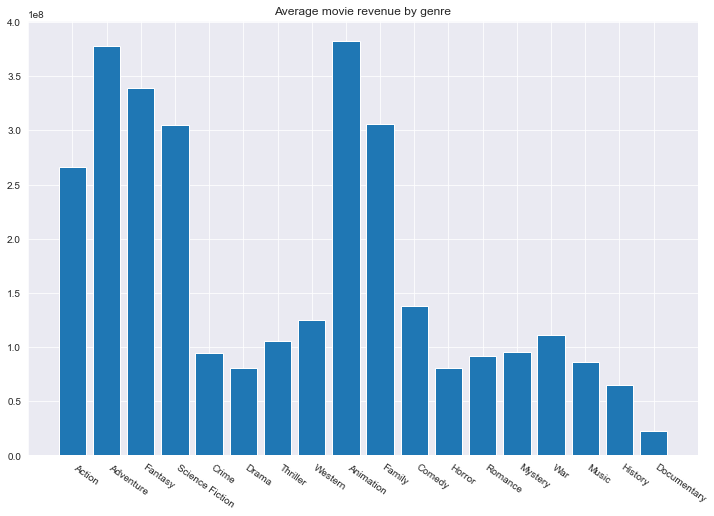

In [571]:
#Dictionary to sort the revenues for each movie by genre
genre_and_revenue={}
for row in tmdb_and_budgets.index:
    g_ids=tmdb_and_budgets.iloc[row]['genre_ids']
    rev=tmdb_and_budgets.iloc[row]['revenue']
    for g in g_ids:
        if g in genre_and_revenue.keys():
            genre_and_revenue[g]=np.append(genre_and_revenue[g], rev)
        else:
            genre_and_revenue[g]=np.array([rev])

#Second dictionary to find just the average revenue for each genre
genre_and_revenue_average={}
for g in genre_and_revenue.keys():
    genre_and_revenue_average[g]=genre_and_revenue[g].mean()

#Plotting the average revenue by genre
fig, ax=plt.subplots(figsize=(12, 8))
ax.bar(genre_and_revenue_average.keys(), genre_and_revenue_average.values())
ax.set_title('Average movie revenue by genre')
ax.set_xticklabels(genre_and_revenue_average.keys(), rotation=-35, ha='left');

In [572]:
#checking to see if genre has a statistically significant impact on revenue
stats.f_oneway(*genre_and_revenue.values())

F_onewayResult(statistic=44.84863384460695, pvalue=3.4563026597519652e-137)

Since the p-value is extremely small and less than 0.05, we conclude that genre does have a statistically significant impact on revenue.

We will now replace the genre ids with the actual genre names, and then analyze the ratio of revenue to budget by genre.

In [573]:
tmdb_and_budgets['revenue_to_budget']=tmdb_and_budgets['revenue']/tmdb_and_budgets['budget']

## Examining return on investment.
We will examine the return on investment for a movie by dividing the box office revenue by the budget.

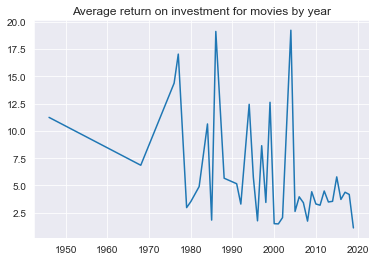

In [574]:
#examining return on investment over time
fig, ax=plt.subplots()
ax.plot(tmdb_and_budgets.groupby('year')['revenue_to_budget'].mean().index, tmdb_and_budgets.groupby('year')['revenue_to_budget'].mean().values)
ax.set_title('Average return on investment for movies by year');

## Which movie genres produce the highest return on investment?

In [575]:
genre_rois={}

for row in tmdb_and_budgets.index:
    g_ids=tmdb_and_budgets.iloc[row]['genre_ids']
    rtb=tmdb_and_budgets.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g]=np.append(genre_rois[g], rtb)
        else:
            genre_rois[g]=np.array([rtb])

genre_rois_average={}
for g in genre_rois.keys():
    genre_rois_average[g]=genre_rois[g].mean()


#### Does genre have a statistically significant impact on return on investment?
Before we make recommendations on which genres to invest in, we must first determine whether genre is statistically significant in our data when it comes to predicting return on investment.

In [576]:
stats.f_oneway(*genre_rois.values())

F_onewayResult(statistic=5.648207136299678, pvalue=7.349557648426371e-13)

Since our p-value is less than 0.05, we conclude that there is a statistically significant difference in return on investment by genre. Therefore we will conduct further analysis to see which genres are the best investments.

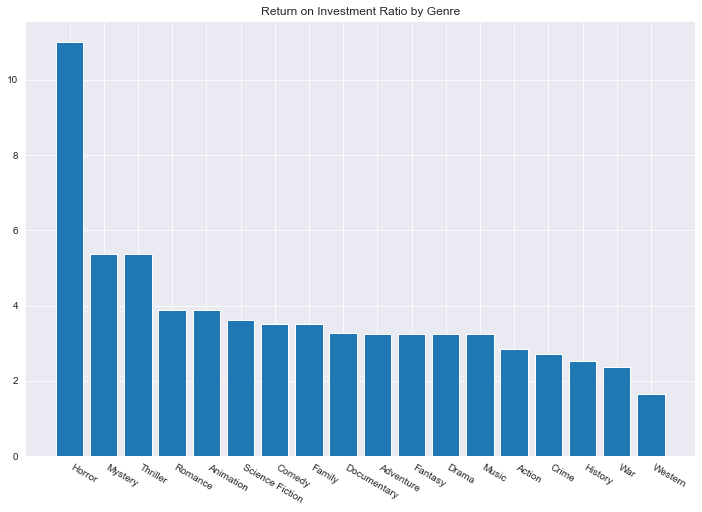

In [577]:
genre_ids=list(genre_rois_average.keys())
rois=list(genre_rois_average.values())
genres_and_rois=pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index, genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre')
ax.set_xticklabels(genres_and_rois.index, rotation=-30, ha='left');

We can see that horror has the highest return on investment, followed by mystery and thriller.

## What about for current movies only? Are the results different?
Our investor asked us to look specifically at how movies are currently doing in the box office, so we will filter the results further to movies released after 2017.

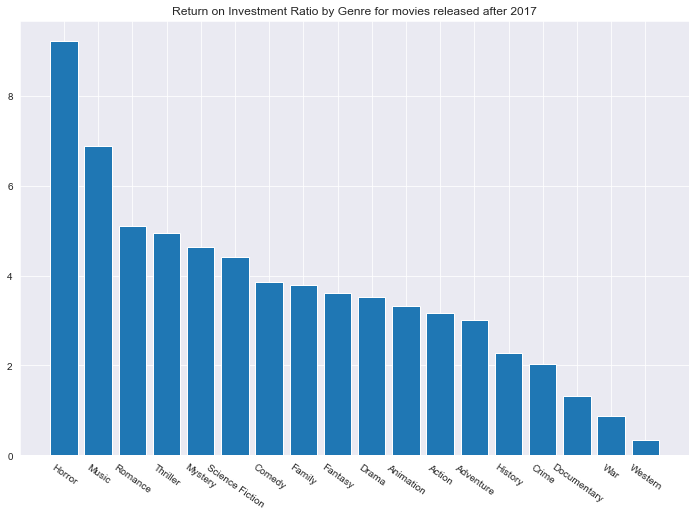

In [578]:
#repeating the same steps as above, but for new movies only

new_movies=tmdb_and_budgets.loc[tmdb_and_budgets['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois={}
for row in new_movies.index:
    g_ids=new_movies.iloc[row]['genre_ids']
    rtb=new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average={}
for g in new_genre_rois.keys():
    new_genre_rois_average[g]=new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois=pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax=plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index, new_movies_genres_and_rois['Return on Investment'])
ax.set_title('Return on Investment Ratio by Genre for movies released after 2017')
ax.set_xticklabels(new_movies_genres_and_rois.index, rotation=-35, ha='center');


Horror still has the highest return on investment, although the gap is not as wide when filtered to new movies only. Music and romance have also done well recently in the box office.

The top genres we recommend are Horror, Romance, Thriller, and Mystery.

## So now that we know what genres are the most profitable, what studios should we pair with? How about directors?

In [579]:
#Preparing movie gross for merge with tmdb_and_budgets
movie_gross['title_and_year']=movie_gross['title']+' ' +movie_gross['year'].astype(str)

In [580]:
#Merging so that we can compare studios, budgets/revenue, and genre.
studios=pd.merge(tmdb_and_budgets, movie_gross, on='title_and_year')

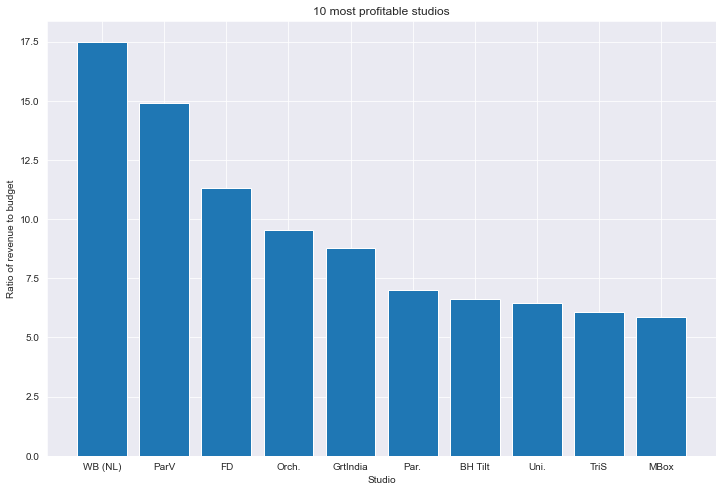

In [581]:
#finding the 10 most profitable studios
profitable_studios=studios.groupby('studio')['revenue_to_budget'].mean().sort_values(ascending=False)[:10]

#displaying the results
fig, ax=plt.subplots(figsize=(12,8))
ax.bar(profitable_studios.index, profitable_studios.values)
ax.set_title('10 most profitable studios');
ax.set_xlabel('Studio')
ax.set_ylabel('Ratio of revenue to budget');

In [582]:
recommended_genres=['Horror', 'Thriller', 'Mystery']
studio_genre_counts={genre:{} for genre in recommended_genres}

for genre in recommended_genres:
    for i in studios.index:
        genres=studios['genre_ids'].iloc[i]
        s=studios['studio'].iloc[i]
        for g in genres:
            if g in studio_genre_counts.keys():
                if s in studio_genre_counts[g].keys():
                    studio_genre_counts[g][s]+=1
                else:
                    studio_genre_counts[g][s]=1
    
#creating a function to find the studio for each genre that has the most films and is among the most profitable studios
def find_studio(genre_dict):
    df=pd.DataFrame(index=genre_dict.keys(), data=genre_dict.values(), columns={'Frequency'}).sort_values(by='Frequency', ascending=False)
    df.loc[df.index.isin(profitable_studios.index)]
    return df.index[0]

for genre in recommended_genres:
    print(f'The most common studio for {genre} movies is {find_studio(studio_genre_counts[genre])}')
      

The most common studio for Horror movies is Uni.
The most common studio for Thriller movies is Uni.
The most common studio for Mystery movies is Uni.


### So we are recommending horrors, thrillers, and mysteries...what studios have been the most profitable within those genres?

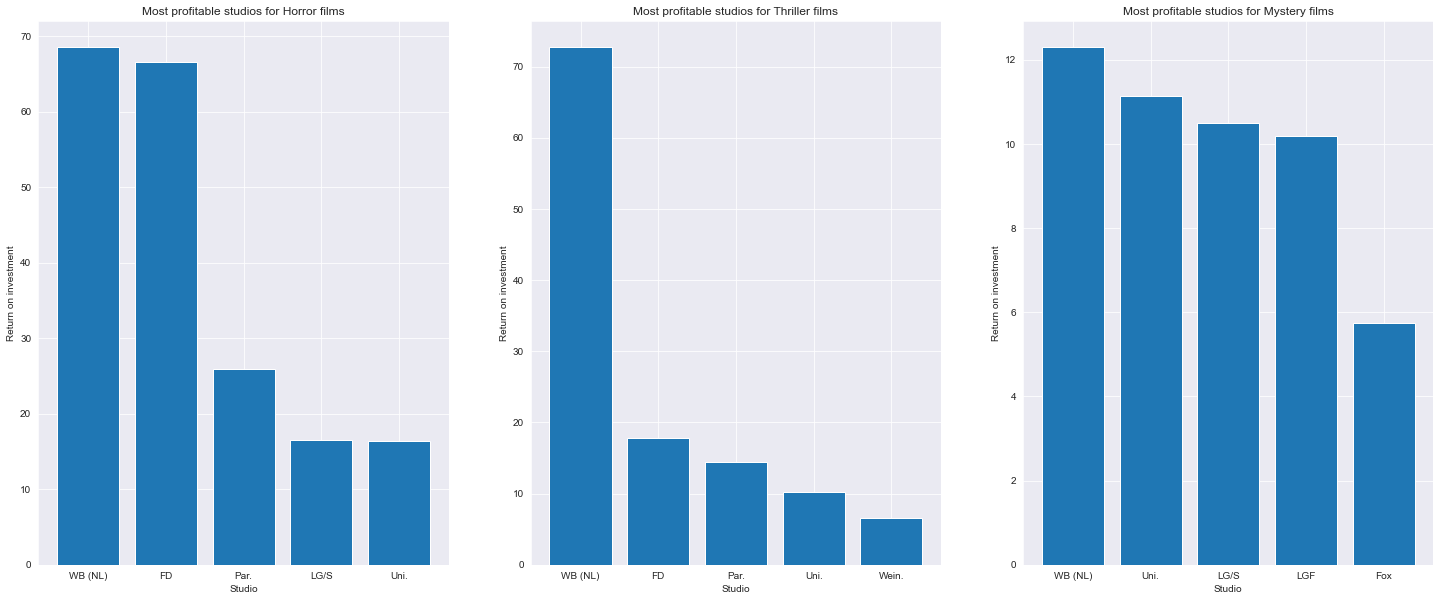

In [583]:
#finding the most profitable studio for each genre
studio_revenue_counts={genre:{} for genre in recommended_genres}
for genre in recommended_genres:
    for i in studios.index:
        genres=studios['genre_ids'].iloc[i]
        s=studios['studio'].iloc[i]
        rtb=studios['revenue_to_budget'].iloc[i]
        for g in genres:
            if g in studio_revenue_counts.keys():
                if s in studio_revenue_counts[g].keys():
                    studio_revenue_counts[g][s]=np.append(studio_revenue_counts[g][s], rtb)
                else:
                    studio_revenue_counts[g][s]=np.array([rtb])

#running a test to see if data is statistically significant
def stat_checker(genre_dict):
    return stats.f_oneway(*genre_dict.values())[1]<0.05

for genre in recommended_genres:
    assert(stat_checker(studio_revenue_counts[genre])==True)

#finding the mean of the return on investments for each studio
fig, ax=plt.subplots(ncols=3, nrows=1, figsize=(25,10))
for i, genre in enumerate(recommended_genres):
    studio_average_roi={}
    for k in studio_revenue_counts[genre].keys():
        studio_average_roi[k]=np.mean(studio_revenue_counts[genre][k])
    df=pd.DataFrame(index=studio_average_roi.keys(), data=studio_average_roi.values(), columns={'Mean_ROI'}).sort_values(by='Mean_ROI', ascending=False)
    ax[i].bar(df.index[:5], df['Mean_ROI'][:5])
    ax[i].set_title(f'Most profitable studios for {genre} films')
    ax[i].set_xlabel('Studio')
    ax[i].set_ylabel('Return on investment')




Warner Brothers is the most profitable studio for all 3 genres, and therefore our top recommendation for a studio to work with. Universal and FD are also good choices.

hi